In [1]:
import glob
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
# import mpld3 
import seaborn as sns
import palettable.colorbrewer.diverging as pld

import numpy as np
import pandas as pd
from sklearn import preprocessing

from scipy import integrate  
#import scipy.signal as scipy
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

%matplotlib widget

In [2]:
plt.close('all')

In [3]:
## Plotting parameters

palette = pld.RdYlGn_4_r
cmap = palette.mpl_colormap
transparency = 0.7
labelsize = 20
spinewidth = 3
fontsize = 26
legendsize = 20
fontweight = 'bold'
labelpad = 6
pad = 10
linewidth = 2.5


# Import analysis functions

In [4]:
%run -i /Users/chenghunglin/Documents/Git_BNL/profile_collection_ldrd20-31/scripts/_data_analysis.py

# Read Uv-Vis data in .csv

## Find the subfolders in the current working folder (cwd)

In [5]:
#cwd = os.getcwd()
cwd = '/Users/chenghunglin/Library/CloudStorage/OneDrive-BrookhavenNationalLaboratory/data_processing/20230726_CsPbBr_ZnI'
subfolder_PL = glob.glob(cwd + '/202**flu**')
subfolder_PL.sort()
del subfolder_PL[0]
print(*subfolder_PL, sep = '\n')  ## Print one element per line

/Users/chenghunglin/Library/CloudStorage/OneDrive-BrookhavenNationalLaboratory/data_processing/20230726_CsPbBr_ZnI/20230726155629_a480718f_fluorescence
/Users/chenghunglin/Library/CloudStorage/OneDrive-BrookhavenNationalLaboratory/data_processing/20230726_CsPbBr_ZnI/20230726161117_9411f16d_fluorescence
/Users/chenghunglin/Library/CloudStorage/OneDrive-BrookhavenNationalLaboratory/data_processing/20230726_CsPbBr_ZnI/20230726162523_20dfaff5_fluorescence
/Users/chenghunglin/Library/CloudStorage/OneDrive-BrookhavenNationalLaboratory/data_processing/20230726_CsPbBr_ZnI/20230726163822_680c1467_fluorescence


In [6]:
# cwd = '/Users/chenghunglin/Library/CloudStorage/OneDrive-BrookhavenNationalLaboratory/data_processing/20230726_CsPbBr_ZnI'
subfolder_Ab = glob.glob(cwd + '/202**abs**')
subfolder_Ab.sort()
del subfolder_Ab[0]
print(*subfolder_Ab, sep = '\n')  ## Print one element per line

/Users/chenghunglin/Library/CloudStorage/OneDrive-BrookhavenNationalLaboratory/data_processing/20230726_CsPbBr_ZnI/20230726155629_a480718f_absorbance
/Users/chenghunglin/Library/CloudStorage/OneDrive-BrookhavenNationalLaboratory/data_processing/20230726_CsPbBr_ZnI/20230726161117_9411f16d_absorbance
/Users/chenghunglin/Library/CloudStorage/OneDrive-BrookhavenNationalLaboratory/data_processing/20230726_CsPbBr_ZnI/20230726162523_20dfaff5_absorbance
/Users/chenghunglin/Library/CloudStorage/OneDrive-BrookhavenNationalLaboratory/data_processing/20230726_CsPbBr_ZnI/20230726163822_680c1467_absorbance


In [7]:
len(subfolder_PL)

4

## Read dark and reference

In [8]:
# dark = cwd + '/' + 'Dark_Abs_20221108-154436_dfc6c06b.csv'
# ref = cwd + '/' + 'TOl_OA_Abs_20221108-154443_1f59eee7.csv'

# dark_df = pd.read_csv(dark, skiprows=2, sep=',')
# ref_df = pd.read_csv(ref, skiprows=2, sep=',')

## Define title and label for plotting

In [9]:
title = [os.path.basename(subfolder_PL[i]) for i in range(len(subfolder_PL))]
print(*title, sep='\n')

#title = ['Insitu CsPb 6mM + Br 6 mM',
title = ['Insitu CsPb 6mM + Br 6 mM + ZnI2 8uL/min', 
         'Insitu CsPb 6mM + Br 6 mM + ZnI2 16uL/min',
         'Insitu CsPb 6mM + Br 6 mM + ZnI2 32uL/min', 
         'Insitu CsPb 6mM + Br 6 mM + ZnI2 64uL/min']
         # 'Insitu CsPb 6mM + Br 6 mM + ZnI2 128uL/min']

#label = ['CsPbBr',
label = ['ZnI2 8 uL/min', 
         'ZnI2 16 uL/min',
         'ZnI2 32 uL/min',
         'ZnI2 64 uL/min']
         # 'ZnI2 128 uL/min']

20230726155629_a480718f_fluorescence
20230726161117_9411f16d_fluorescence
20230726162523_20dfaff5_fluorescence
20230726163822_680c1467_fluorescence


## Plot all fluorescence data and put avergae into pd.Dataframe()

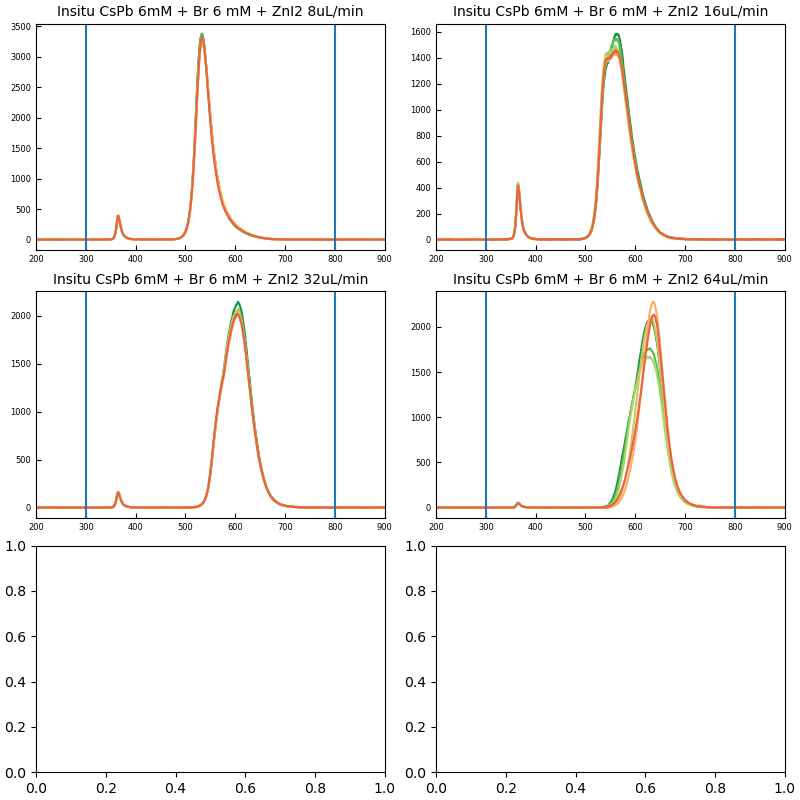

In [10]:
rows = 3
cols = 2
f1, ax1 = plt.subplots(rows, cols, figsize = (8, 8), constrained_layout=True)
# f1, (ax1, ax2) = plt.subplots(1, 2, figsize = (6, 9), gridspec_kw={'width_ratios': [1,1]})

ax1 = ax1.flatten()
df = pd.DataFrame()
# df_norm = pd.DataFrame()
df_norm2 = pd.DataFrame()

## Wavelength range
wl1 = 300
wl2 = 800

id0 = 0
id1 = 12
# skiprows = 11 ## skip 23 rows if data processed by dioptas or ## 8
for i in range(len(subfolder_PL)):
    # data_files = subfolder_PL
    data_files = glob.glob(subfolder_PL[i] + '/**.csv')
    data_files.sort()
    del data_files[-1]
    
    ## Data file range
    k1 = 0
    k2 = len(data_files)
    color_idx = np.linspace(0, 1, k2-k1+1)
    #ax1[i].set_title(os.path.basename(subfolder[i]), {'fontsize': 14, 'fontweight': fontweight})
    ax1[i].set_title(title[i], fontsize=10)
    
    suffix = os.path.basename(data_files[0])
    if i==-2:
        skiprows=4
        xlabel = 'Energy'
    else:
        skiprows=11
        xlabel = 'Wavelength'
    
    df_temp = pd.DataFrame()
    df_int = pd.DataFrame()
   
    ### plot every scan in subplots
    for j in range(len(data_files)):        
        df_temp = pd.read_csv(data_files[j], skiprows=skiprows, sep=',')
        # df_temp = pd.concat([df_temp, df[f'{suffix[id0:id1]}'], axis=1, ignore_index=False)
        df_int = pd.concat([df_int, df_temp['Fluorescence']], axis=1, ignore_index=False)
        ax1[i].plot(df_temp[f'{xlabel}'], df_temp['Fluorescence'], color=cmap(color_idx[j-k1]))      
    df_temp['Fluorescence_mean'] = df_int.mean(axis=1)
    # ax1[i].plot(df_temp[f'{xlabel}'], df_temp['Fluorescence_mean'], 'b--')
    
    ### Put average data into df
    df[f'x_{suffix[id0:id1]}'] = df_temp[f'{xlabel}']
    df[f'PL_{suffix[id0:id1]}'] = df_temp['Fluorescence_mean']
    
    
    ### Plot vertical lines to show nromalized range
    idx1, w1 = find_nearest(df[f'x_{suffix[id0:id1]}'], wl1)
    idx2, w2 = find_nearest(df[f'x_{suffix[id0:id1]}'], wl2)
    ax1[i].axvline(w1)
    ax1[i].axvline(w2)
    
    ### Put normalized average data into df_norm2
    x = df[f'PL_{suffix[id0:id1]}'].loc[idx1:idx2].values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x.reshape(-1,1))
    df_norm2[f'x_{suffix[id0:id1]}'] = df[f'x_{suffix[id0:id1]}'].loc[idx1:idx2].values
    df_norm2[f'PL_{suffix[id0:id1]}']= x_scaled.flatten()
    
    ax1[i].set_xlim(200, 900)
    # ax1[i].set_ylim(-0.1, max(PL[100:800])+0.2)
    ax1[i].tick_params(axis='both', direction='in', labelsize=6)

In [11]:
df

x_CsPbI3_08ul_  PL_CsPbI3_08ul_  x_CsPbI3_16ul_  PL_CsPbI3_16ul_  \
0         197.742294         0.592593      197.742294         0.944444   
1         198.544478         0.592593      198.544478         0.870370   
2         199.346597         0.388889      199.346597         0.740741   
3         200.148650         1.629630      200.148650         1.351852   
4         200.950637         0.666667      200.950637         0.814815   
...              ...              ...             ...              ...   
1039      990.769837         1.685185      990.769837         1.407407   
1040      991.489165         0.629630      991.489165         0.814815   
1041      992.208398         1.629630      992.208398         2.092593   
1042      992.927537         1.333333      992.927537         1.129630   
1043      993.646582         0.925926      993.646582         1.666667   

      x_CsPbI3_32ul_  PL_CsPbI3_32ul_  x_CsPbI3_64ul_  PL_CsPbI3_64ul_  
0         197.742294         0.444444      197.742294         0.592593  
1         198.544478         0.722222      198.544478         1.037037  
2         199.346597         0.611111      199.346597         0.444444  
3         200.148650         1.574074      200.148650         1.611111  
4         200.950637         0.814815      200.950637         1.685185  
...              ...              ...             ...              ...  
1039      990.769837         2.185185      990.769837         1.462963  
1040      991.489165         0.500000      991.489165         1.185185  
1041      992.208398         1.944444      992.208398         1.296296  
1042      992.927537         1.037037      992.927537         1.055556  
1043      993.646582         1.259259      993.646582         1.240741  

[1044 rows x 8 columns]

### Define keys for df

In [12]:
keys_list = list(df.keys())
# k1 = [k for k in keys_list if 'mean' in k]
keys_list

['x_CsPbI3_08ul_',
 'PL_CsPbI3_08ul_',
 'x_CsPbI3_16ul_',
 'PL_CsPbI3_16ul_',
 'x_CsPbI3_32ul_',
 'PL_CsPbI3_32ul_',
 'x_CsPbI3_64ul_',
 'PL_CsPbI3_64ul_']

## Plot average PL profiles in df

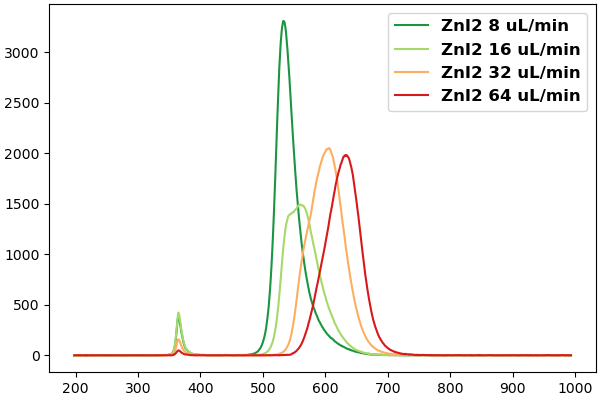

In [13]:
f2, ax2 = plt.subplots(1, 1, figsize = (6, 4), constrained_layout=True)
# f1, (ax1, ax2) = plt.subplots(1, 2, figsize = (6, 9), gridspec_kw={'width_ratios': [1,1]})

k = len(subfolder_PL)
color_idx = np.linspace(0, 1, k)
for i in range(len(subfolder_PL)):
    #ax2.set_title(os.path.basename(subfolder[i]), {'fontsize': 14, 'fontweight': fontweight})
    ax2.plot(df[keys_list[i*2]], df[keys_list[i*2+1]], color=cmap(color_idx[i]), label=label[i])

legend_properties = {'weight':'bold', 'size':12}    
ax2.legend(fontsize=legendsize, prop=legend_properties)

## Plot normalized PL profiles in df_norm2

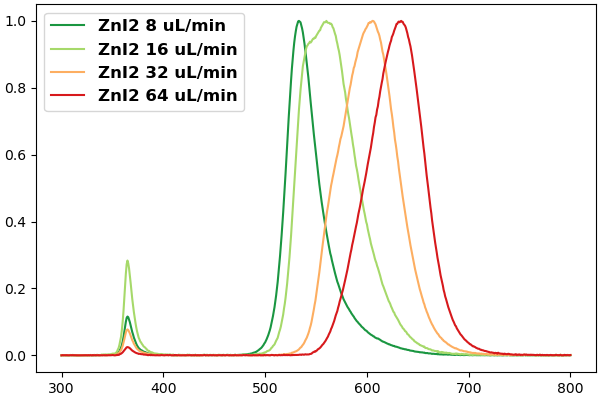

In [14]:
f3, ax3 = plt.subplots(1, 1, figsize = (6, 4), constrained_layout=True)
# f1, (ax1, ax2) = plt.subplots(1, 2, figsize = (6, 9), gridspec_kw={'width_ratios': [1,1]})

k = len(subfolder_PL)
color_idx = np.linspace(0, 1, k)
for i in range(len(subfolder_PL)):
    #ax3.set_title(os.path.basename(subfolder[i]), {'fontsize': 14, 'fontweight': fontweight})
    ax3.plot(df_norm2[keys_list[i*2]], df_norm2[keys_list[i*2+1]], color=cmap(color_idx[i]), label=label[i])

legend_properties = {'weight':'bold', 'size':12}    
ax3.legend(fontsize=legendsize, prop=legend_properties)

## Gaussian peak fittimg

PL_CsPbI3_08ul_ passes c1 so is good.

** Average of PL_CsPbI3_08ul_ has peaks at [171]**


** start to do peak fitting by Gaussian**

PL_CsPbI3_16ul_ passes c1 so is good.

** Average of PL_CsPbI3_16ul_ has peaks at [206]**


** start to do peak fitting by Gaussian**

PL_CsPbI3_32ul_ passes c1 so is good.

** Average of PL_CsPbI3_32ul_ has peaks at [265]**


** start to do peak fitting by Gaussian**

PL_CsPbI3_64ul_ passes c1 so is good.

** Average of PL_CsPbI3_64ul_ has peaks at [302]**


** start to do peak fitting by Gaussian**



Text(0, 0.5, 'PLQY')

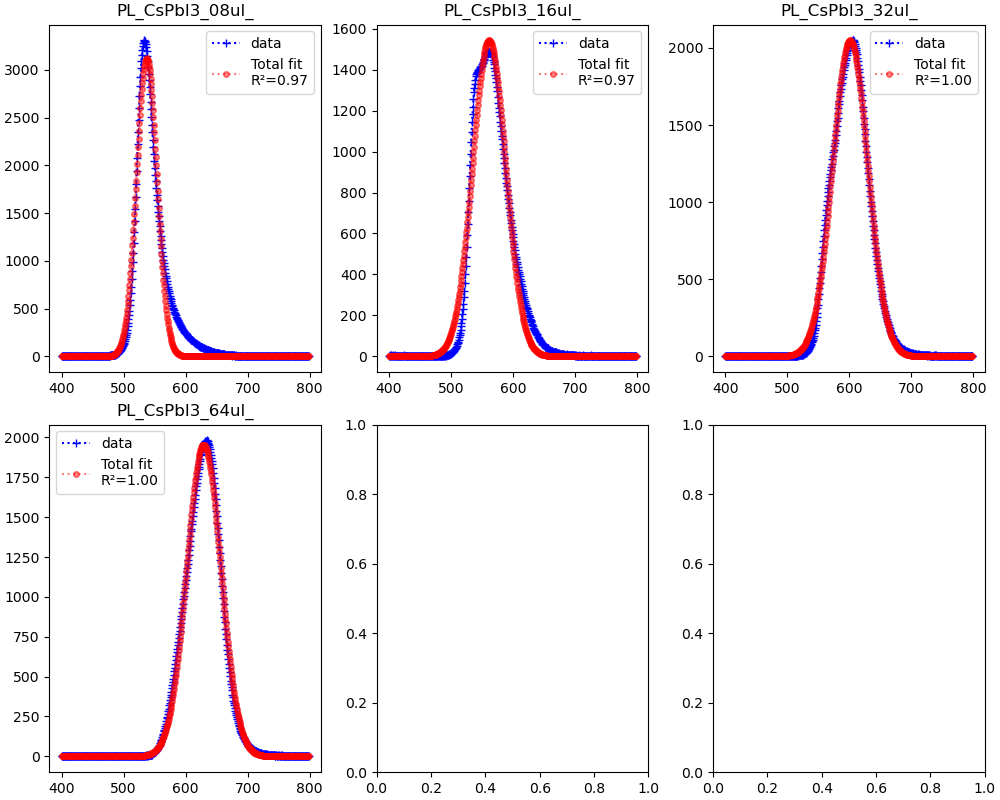

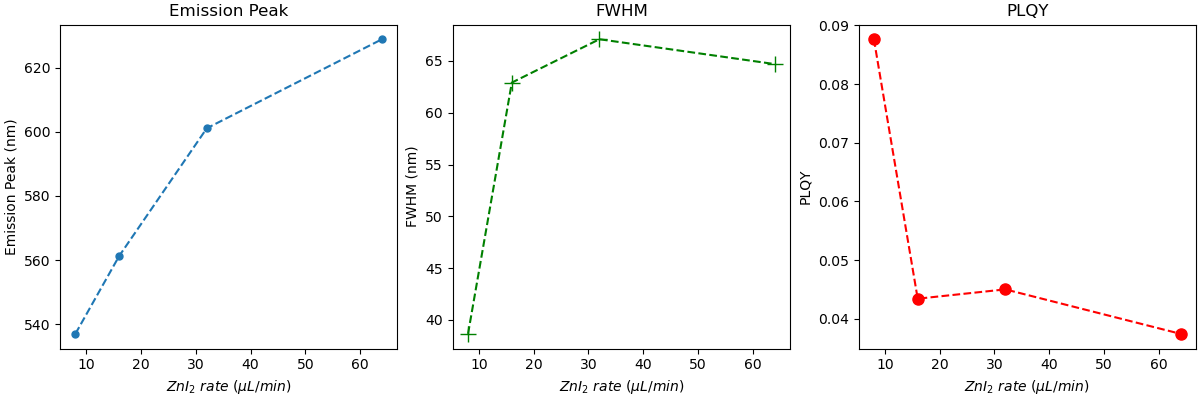

In [15]:
f4, ax4 = plt.subplots(2, 3, figsize = (10, 8), constrained_layout=True)
ax4 = ax4.flatten()
wl1 = 400
wl2 = 800
idx1, w1 = find_nearest(df[keys_list[0]], wl1)
idx2, w2 = find_nearest(df[keys_list[0]], wl2)

peak_list = []
fwhm = []
simpson_int = []

for i in range(len(subfolder_PL)):
    #i = 4
    x0 = df[keys_list[i*2]][idx1:idx2].to_numpy()
    y0 = df[keys_list[i*2+1]][idx1:idx2].to_numpy()
    #_2peak_fit_PL(x,y, distr='G', height=1000, second_peak=-4, plot=True, plot_title=os.path.basename(subfolder[i]))
    
    peak, prop = good_bad_data(x0, y0, key_height=500, data_id = f'{keys_list[i*2+1]}', distance=50, height=200)
    x, y, p, f, popt = _fitting_in_kafka(x0, y0, f'{keys_list[i*2+1]}', peak, prop)  
    
    
    simpson_int.append(integrate.simpson(y,x))
    peak_list.append(popt[1])
    fwhm.append(2.355*popt[2])
    
    
    fitted_result = f(x, *popt)
    r_2 = r_square(x, y, fitted_result)
    r2 = f'R\u00b2={r_2:.2f}'
    ax4[i].set_title(f'{keys_list[i*2+1]}')
    ax4[i].plot(x,y,'b+:',label='data')
    ax4[i].plot(x,fitted_result,'ro:',label='Total fit\n'+r2, alpha=0.5, markersize=4)
    
#     # peak 1
#     peak_1 = _1gauss(x, *popt[0:3])
#     ax4[i].plot(x, peak_1, "g", label='peak 1')
#     ax4[i].fill_between(x, peak_1.min(), peak_1, facecolor="green", alpha=0.5)

#     # peak 2
#     peak_2 = _1gauss(x, *popt[3:6])
#     ax4[i].plot(x, peak_2, "y", label='peak 2')
#     ax4[i].fill_between(x, peak_2.min(), peak_2, facecolor="yellow", alpha=0.5)
    
    ax4[i].legend()


# abs_365 = np.asarray([0.458828, 0.373916, 0.656800, 1.052980, 1.582505, 1.302717])
# abs_365 = np.asarray([0.45788178937234225, 0.906788585562671, 1.3468533683956367, 1.8042517715092394, 2.0145695678124844])
abs_365 = np.asarray([0.906788585562671, 1.3468533683956367, 1.8042517715092394, 2.0145695678124844])
abs_365_r = 0.376390
plqy_r = 0.546
ref_idx_toluene = 1.506
ref_idx_H2SO4 = 1.337
integral_r = 468573.0
integral_pqds = np.asarray(simpson_int)

plqy = plqy_r*abs_365_r*(ref_idx_toluene**2)*integral_pqds / (integral_r*(ref_idx_H2SO4**2)*abs_365)
    
f5, ax5 = plt.subplots(1, 3, figsize = (12, 4), constrained_layout=True)
ax5[0].set_title('Emission Peak')
ax5[0].plot([8,16,32,64], peak_list, '.--', markersize=10)
ax5[0].set_xlabel(r'$ZnI_2\ rate\ (\mu L/min)$', fontdict={'size': 10})
ax5[0].set_ylabel('Emission Peak (nm)')

ax5[1].set_title('FWHM')
ax5[1].plot([8,16,32,64], fwhm, 'g+--', markersize=12)
ax5[1].set_xlabel(r'$ZnI_2\ rate\ (\mu L/min)$', fontdict={'size': 10})
ax5[1].set_ylabel('FWHM (nm)')

ax5[2].set_title('PLQY')
ax5[2].plot([8,16,32,64], plqy, 'ro--', markersize=8)
ax5[2].set_xlabel(r'$ZnI_2\ rate\ (\mu L/min)$', fontdict={'size': 10})
ax5[2].set_ylabel('PLQY')

In [16]:
integral_pqds

array([142839.64342002, 105111.66639376, 145959.68358556, 135546.43825137])

## Plot all absorbance data and put avergae into pd.Dataframe()

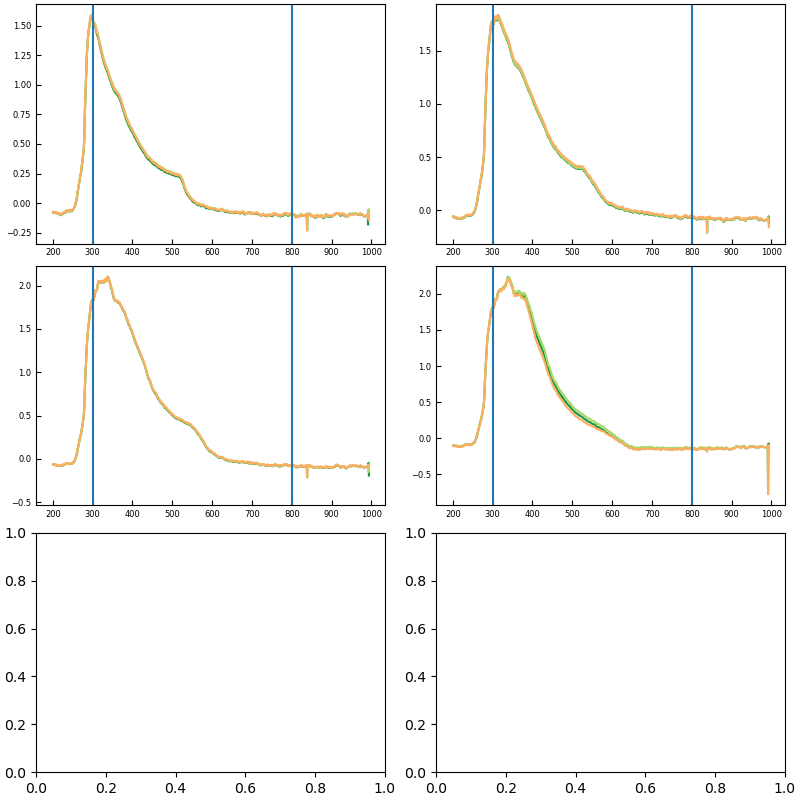

In [17]:
rows = 3
cols = 2
f11, ax11 = plt.subplots(rows, cols, figsize = (8, 8), constrained_layout=True)
# f1, (ax1, ax2) = plt.subplots(1, 2, figsize = (6, 9), gridspec_kw={'width_ratios': [1,1]})

ax11 = ax11.flatten()
df = pd.DataFrame()
# df_norm = pd.DataFrame()
df_norm2 = pd.DataFrame()

## Wavelength range
wl1 = 300
wl2 = 800

id0 = 0
id1 = 12
# skiprows = 11 ## skip 23 rows if data processed by dioptas or ## 8
for i in range(len(subfolder_Ab)):
    # data_files = subfolder_PL
    data_files = glob.glob(subfolder_Ab[i] + '/**.csv')
    data_files.sort()
    del data_files[0]
    
    ## Data file range
    k1 = 0
    k2 = len(data_files)
    color_idx = np.linspace(0, 1, k2-k1+1)
    #ax1[i].set_title(os.path.basename(subfolder[i]), {'fontsize': 14, 'fontweight': fontweight})
    ax1[i].set_title(title[i], fontsize=10)
    
    suffix = os.path.basename(data_files[0])
    if i==-10:
        skiprows=4
        xlabel = 'Energy'
    else:
        skiprows=11
        xlabel = 'Wavelength'
    
    df_temp = pd.DataFrame()
    df_int = pd.DataFrame()
   
    ### plot every scan in subplots
    for j in range(len(data_files)):        
        df_temp = pd.read_csv(data_files[j], skiprows=skiprows, sep=',')
        # df_temp = pd.concat([df_temp, df[f'{suffix[id0:id1]}'], axis=1, ignore_index=False)
        df_int = pd.concat([df_int, df_temp['Absorbance']], axis=1, ignore_index=False)
        ax11[i].plot(df_temp[f'{xlabel}'], df_temp['Absorbance'], color=cmap(color_idx[j-k1]))      
    df_temp['Absorbance_mean'] = df_int.mean(axis=1)
    # ax1[i].plot(df_temp[f'{xlabel}'], df_temp['Fluorescence_mean'], 'b--')
    
    ### Put average data into df
    df[f'x_{suffix[id0:id1]}'] = df_temp[f'{xlabel}']
    df[f'Ab_{suffix[id0:id1]}'] = df_temp['Absorbance_mean']
    
    
    ### Plot vertical lines to show nromalized range
    idx1, w1 = find_nearest(df[f'x_{suffix[id0:id1]}'], wl1)
    idx2, w2 = find_nearest(df[f'x_{suffix[id0:id1]}'], wl2)
    ax11[i].axvline(w1)
    ax11[i].axvline(w2)
    
    ### Put normalized average data into df_norm2
    x = df[f'Ab_{suffix[id0:id1]}'].loc[idx1:idx2].values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x.reshape(-1,1))
    df_norm2[f'x_{suffix[id0:id1]}'] = df[f'x_{suffix[id0:id1]}'].loc[idx1:idx2].values
    df_norm2[f'Ab_{suffix[id0:id1]}']= x_scaled.flatten()
    
    # ax11[i].set_xlim(200, 900)
    # ax1[i].set_ylim(-0.1, max(PL[100:800])+0.2)
    ax11[i].tick_params(axis='both', direction='in', labelsize=6)

In [18]:
df

x_CsPbI3_08ul_  Ab_CsPbI3_08ul_  x_CsPbI3_16ul_  Ab_CsPbI3_16ul_  \
0         197.742294        -0.029860      197.742294         0.112129   
1         198.544478              NaN      198.544478              NaN   
2         199.346597              NaN      199.346597              NaN   
3         200.148650              NaN      200.148650              NaN   
4         200.950637        -0.076789      200.950637        -0.058466   
...              ...              ...             ...              ...   
1039      990.769837        -0.095240      990.769837        -0.081358   
1040      991.489165        -0.145672      991.489165        -0.081543   
1041      992.208398        -0.079537      992.208398        -0.082221   
1042      992.927537        -0.093985      992.927537        -0.088181   
1043      993.646582        -0.129654      993.646582        -0.126752   

      x_CsPbI3_32ul_  Ab_CsPbI3_32ul_  x_CsPbI3_64ul_  Ab_CsPbI3_64ul_  
0         197.742294        -0.283593      197.742294        -0.190775  
1         198.544478              NaN      198.544478              NaN  
2         199.346597              NaN      199.346597              NaN  
3         200.148650              NaN      200.148650              NaN  
4         200.950637        -0.064325      200.950637        -0.103342  
...              ...              ...             ...              ...  
1039      990.769837        -0.080414      990.769837        -0.113065  
1040      991.489165        -0.082922      991.489165        -0.695121  
1041      992.208398        -0.067915      992.208398        -0.095453  
1042      992.927537        -0.094725      992.927537        -0.111349  
1043      993.646582        -0.110737      993.646582        -0.171288  

[1044 rows x 8 columns]

In [19]:
keys_list2 = list(df.keys())
# k1 = [k for k in keys_list if 'mean' in k]
keys_list2

['x_CsPbI3_08ul_',
 'Ab_CsPbI3_08ul_',
 'x_CsPbI3_16ul_',
 'Ab_CsPbI3_16ul_',
 'x_CsPbI3_32ul_',
 'Ab_CsPbI3_32ul_',
 'x_CsPbI3_64ul_',
 'Ab_CsPbI3_64ul_']

In [20]:
idx_365, w365 = find_nearest(df[keys_list2[0]], 365)
df.iloc[idx_365][::-2][::-1].to_list()
idx_365

210

In [21]:
df.iloc[210:220]

x_CsPbI3_08ul_  Ab_CsPbI3_08ul_  x_CsPbI3_16ul_  Ab_CsPbI3_16ul_  \
210      364.721267         0.916058      364.721267         1.350698   
211      365.509089         0.910565      365.509089         1.349976   
212      366.296840         0.906789      366.296840         1.346853   
213      367.084519         0.900757      367.084519         1.341109   
214      367.872128         0.893218      367.872128         1.336084   
215      368.659665         0.888262      368.659665         1.330968   
216      369.447130         0.880615      369.447130         1.326333   
217      370.234524         0.873683      370.234524         1.317789   
218      371.021847         0.867755      371.021847         1.313901   
219      371.809098         0.858112      371.809098         1.306532   

     x_CsPbI3_32ul_  Ab_CsPbI3_32ul_  x_CsPbI3_64ul_  Ab_CsPbI3_64ul_  
210      364.721267         1.805538      364.721267         2.010361  
211      365.509089         1.809726      365.509089         2.019329  
212      366.296840         1.804252      366.296840         2.014570  
213      367.084519         1.805381      367.084519         2.019783  
214      367.872128         1.798484      367.872128         2.009202  
215      368.659665         1.789775      368.659665         2.002564  
216      369.447130         1.783445      369.447130         2.000599  
217      370.234524         1.771216      370.234524         1.986340  
218      371.021847         1.770308      371.021847         1.987827  
219      371.809098         1.763306      371.809098         1.982587